In [1]:
import torch
from torch.autograd import Variable
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import pandas as pd

import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


# Load and format  data

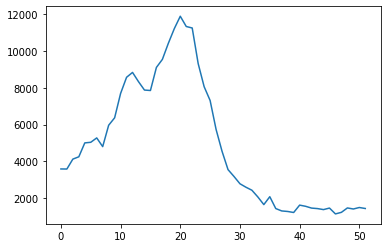

In [2]:
# Load Dataset
ilinet_full = pd.DataFrame(pd.read_csv('ILINet.csv'))
ilinet_full_seasons =ilinet_full[0:782]
data = ilinet_full_seasons['ILITOTAL'].values
#scaler = MinMaxScaler(feature_range=(-1, 1))
#data=scaler.fit_transform(ilinet_full_seasons['ILITOTAL'].values.reshape(-1, 1))

# format data to be seasonal
end_weeks=ilinet_full_seasons.index[ilinet_full_seasons['WEEK'] == 39].tolist()
start_weeks=ilinet_full_seasons.index[ilinet_full_seasons['WEEK'] == 40].tolist()

seasons=[]
for i in range(len(start_weeks)):
    c=start_weeks[i]
    seasons.append(data[c:c+52])
seasons=np.vstack(seasons)
plt.plot(seasons[1])

In [3]:
#scaler = MinMaxScaler(feature_range=(-1, 1))
#maxval = seasons.max()
#minval = seasons.min()
#scaleddata = scaler.fit_transform(seasons[0:-1].reshape(-1, 1))
#full_data = torch.FloatTensor(scaleddata).view(-1)
#plt.plot(full_data)
normalized_seasons=(seasons-seasons.min())/(seasons.max()-seasons.min())

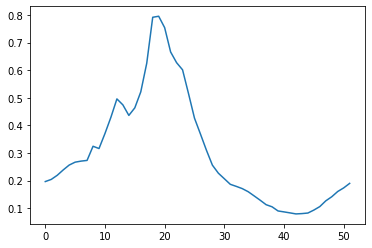

In [4]:
plt.plot(normalized_seasons[-1])

# Implement Seq2Seq 
Adapted from
https://github.com/JEddy92/TimeSeries_Seq2Seq/blob/master/notebooks/TS_Seq2Seq_Intro.ipynb


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")


In [6]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense
from keras.optimizers import Adam

latent_dim = 50 # LSTM hidden units
dropout = .20 

# Define an input series and encode it with an LSTM. 
encoder_inputs = Input(shape=(None, 1)) 
encoder = LSTM(latent_dim, dropout=dropout, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# We discard `encoder_outputs` and only keep the final states. These represent the "context"
# vector that we use as the basis for decoding.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
# This is where teacher forcing inputs are fed in.
decoder_inputs = Input(shape=(None, 1)) 

# We set up our decoder using `encoder_states` as initial state.  
# We return full output sequences and return internal states as well. 
# We don't use the return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, dropout=dropout, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,initial_state=encoder_states)

decoder_dense = Dense(1) # 1 continuous output at each timestep
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


In [7]:
def transform_series_encode(series_array):
    series_mean = series_array.mean(axis=1).reshape(-1,1) 
    series_array = series_array #- series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array, series_mean

def transform_series_decode(series_array, encode_series_mean):
    series_array = series_array - np.zeros([len(encode_series_mean),1])#encode_series_mean
    series_array = series_array.reshape((series_array.shape[0],series_array.shape[1], 1))
    
    return series_array

In [8]:
encoder_input_data = normalized_seasons[0:-2]
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

decoder_target_data = normalized_seasons[-2]
decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)

In [9]:
#first_n_samples = 20000
batch_size = 2**11
epochs = 100

# sample of series from train_enc_start to train_enc_end  
encoder_input_data = normalized_seasons[0:-2]#get_time_block_series(series_array, date_to_index, 
                                           #train_enc_start, train_enc_end)[:first_n_samples]
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

# sample of series from train_pred_start to train_pred_end 
decoder_target_data = normalized_seasons[-2]#get_time_block_series(series_array, date_to_index, 
                                            #train_pred_start, train_pred_end)[:first_n_samples]
decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)

# lagged target series for teacher forcing
decoder_input_data = np.zeros(decoder_target_data.shape)
decoder_input_data[:,1:,0] = decoder_target_data[:,:-1,0]
decoder_input_data[:,0,0] = encoder_input_data[:,-1,0]

model.compile(Adam(), loss='mean_absolute_error')
history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
                     batch_size=batch_size,
                     epochs=epochs,
                     validation_split=0.2);

Instructions for updating:
Use tf.cast instead.
Train on 10 samples, validate on 3 samples
Epoch 1/100
10/10 [==============================] - 1s 78ms/step - loss: 0.2715 - val_loss: 0.2488
Epoch 2/100
10/10 [==============================] - 0s 5ms/step - loss: 0.2477 - val_loss: 0.2281
Epoch 3/100
10/10 [==============================] - 0s 5ms/step - loss: 0.2266 - val_loss: 0.2073
Epoch 4/100
10/10 [==============================] - 0s 5ms/step - loss: 0.2080 - val_loss: 0.1881
Epoch 5/100
10/10 [==============================] - 0s 4ms/step - loss: 0.2047 - val_loss: 0.1756
Epoch 6/100
10/10 [==============================] - 0s 5ms/step - loss: 0.1770 - val_loss: 0.1691
Epoch 7/100
10/10 [==============================] - 0s 5ms/step - loss: 0.1764 - val_loss: 0.1652
Epoch 8/100
10/10 [==============================] - 0s 4ms/step - loss: 0.1768 - val_loss: 0.1627
Epoch 9/100
10/10 [==============================] - 0s 4ms/step - loss: 0.1683 - val_loss: 0.1603
Epoch 10/100
10/1

10/10 [==============================] - 0s 4ms/step - loss: 0.0504 - val_loss: 0.0460
Epoch 81/100
10/10 [==============================] - 0s 4ms/step - loss: 0.0503 - val_loss: 0.0436
Epoch 82/100
10/10 [==============================] - 0s 4ms/step - loss: 0.0484 - val_loss: 0.0415
Epoch 83/100
10/10 [==============================] - 0s 4ms/step - loss: 0.0459 - val_loss: 0.0426
Epoch 84/100
10/10 [==============================] - 0s 5ms/step - loss: 0.0463 - val_loss: 0.0392
Epoch 85/100
10/10 [==============================] - 0s 5ms/step - loss: 0.0417 - val_loss: 0.0395
Epoch 86/100
10/10 [==============================] - 0s 5ms/step - loss: 0.0419 - val_loss: 0.0409
Epoch 87/100
10/10 [==============================] - 0s 4ms/step - loss: 0.0416 - val_loss: 0.0405
Epoch 88/100
10/10 [==============================] - 0s 4ms/step - loss: 0.0431 - val_loss: 0.0380
Epoch 89/100
10/10 [==============================] - 0s 4ms/step - loss: 0.0399 - val_loss: 0.0380
Epoch 90/100


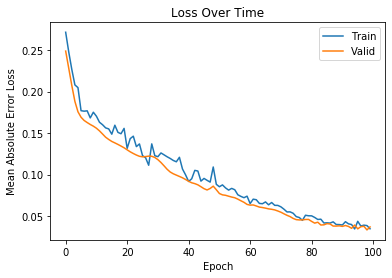

In [10]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error Loss')
plt.title('Loss Over Time')
plt.legend(['Train','Valid'])

In [11]:
# from our previous model - mapping encoder sequence to state vectors
encoder_model = Model(encoder_inputs, encoder_states)

# A modified version of the decoding stage that takes in predicted target inputs
# and encoded state vectors, returning predicted target outputs and decoder state vectors.
# We need to hang onto these state vectors to run the next step of the inference loop.
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]

decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs,
                      [decoder_outputs] + decoder_states)

def decode_sequence(input_seq):
    
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, 1))
    
    # Populate the first target sequence with end of encoding series pageviews
    target_seq[0, 0, 0] = input_seq[0, -1, 0]

    # Sampling loop for a batch of sequences - we will fill decoded_seq with predictions
    # (to simplify, here we assume a batch of size 1).

    decoded_seq = np.zeros((1,pred_steps,1))
    
    for i in range(pred_steps):
        
        output, h, c = decoder_model.predict([target_seq] + states_value)
        
        decoded_seq[0,i,0] = output[0,0,0]

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, 1))
        target_seq[0, 0, 0] = output[0,0,0]

        # Update states
        states_value = [h, c]

    return decoded_seq

In [14]:
encoder_input_data = normalized_seasons[0:-1]
encoder_input_data, encode_series_mean = transform_series_encode(encoder_input_data)

decoder_target_data = normalized_seasons[-1]
decoder_target_data = transform_series_decode(decoder_target_data, encode_series_mean)

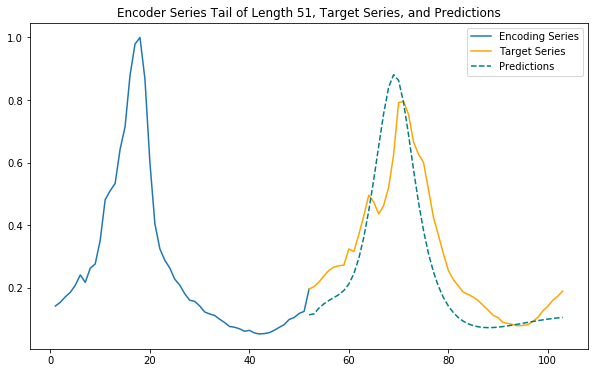

In [15]:
pred_steps=52
def predict_and_plot(encoder_input_data, decoder_target_data, sample_ind, enc_tail_len=51):
    encode_series = encoder_input_data[sample_ind:sample_ind+1] 
    pred_series = decode_sequence(encode_series)
    
    encode_series = encode_series.reshape(-1,1)
    pred_series = pred_series.reshape(-1,1)   
    target_series = decoder_target_data[sample_ind,:].reshape(-1,1) 
    encode_series_tail = np.concatenate([encode_series[-enc_tail_len:],target_series[:1]])
    x_encode = encode_series_tail.shape[0]
    
    plt.figure(figsize=(10,6))  
    plt.plot(range(1,x_encode+1),encode_series_tail)
    plt.plot(range(x_encode,x_encode+pred_steps),target_series,color='orange')
    plt.plot(range(x_encode,x_encode+pred_steps),pred_series,color='teal',linestyle='--')
    
    plt.title('Encoder Series Tail of Length %d, Target Series, and Predictions' % enc_tail_len)
    plt.legend(['Encoding Series','Target Series','Predictions'])
    return pred_series
preds= predict_and_plot(encoder_input_data, decoder_target_data, 13)

In [17]:
unscaled =preds*(seasons.max()-seasons.min())+seasons.min()

Difference in Peak Value:
LSTM Predictions: 7446.800046622753

Difference in Peak Week:
LSTM Predictions: 2


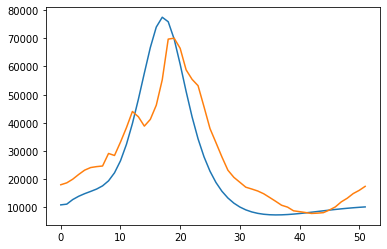

In [20]:
plt.plot(unscaled)
plt.plot(seasons[-1])
print("Difference in Peak Value:")
print("LSTM Predictions:",abs(unscaled.max() - seasons[-1].max()))
print("")
print("Difference in Peak Week:")
print("LSTM Predictions:",abs(np.argmax(unscaled) - np.argmax(seasons[-1])))